In [8001]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [8002]:
import wntr
import pandas as pd
import numpy as np
import copy
import networkx as nx
import torch
from wntr.graphics import plot_network
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix

In [8003]:
inp_file = 'tsnet.inp'

### Network Topology Without Leak Junctions

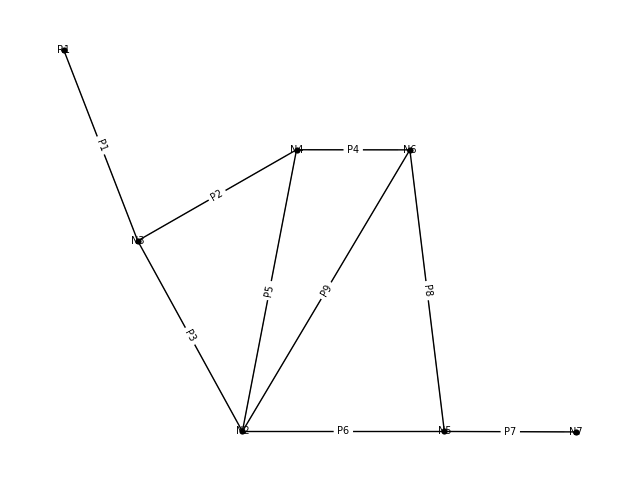

In [8004]:
# Plot just the structure of the network
base_wn = wntr.network.WaterNetworkModel(inp_file)

display(Markdown("### Network Topology Without Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [8005]:
n_pipes = len(base_wn.pipe_name_list)
pipe_names = [f'P{1+i}' for i in range(n_pipes)] 
leak_junctions = [f'LEAK-{i}' for i in range(n_pipes)] 

In [8006]:
for i, pn in enumerate(pipe_names):
    base_wn = wntr.morph.split_pipe(base_wn, pn, pn + '_B', f'LEAK-{i}')

### Network Topology With Leak Junctions

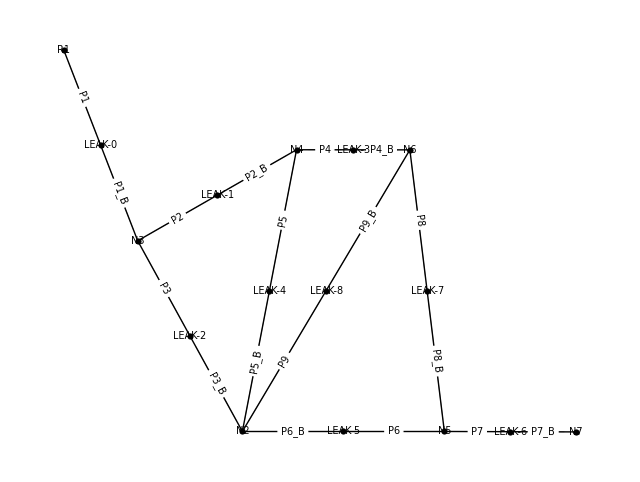

In [8007]:
# Plot just the structure of the network

display(Markdown("### Network Topology With Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [ ]:
Cd = 0.75
diameter = 1

base_leak = 0

leak_ratio = np.array([0.3, 0.0])
leak_areas = 3.14159 * (diameter*leak_ratio / 2) ** 2


supply_nodes = base_wn.reservoir_name_list
flow_data = []
leak_junctions = [f'LEAK-{i}' for i in range(n_pipes)] 

for leak_node_id in leak_junctions:

    for area in leak_areas:
        wn = copy.deepcopy(base_wn)

        # Add leak at specified node
        junction = wn.get_node(leak_node_id)
        junction.add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)
        
        
        # try:
        #     junction = wn.get_node(f'LEAK-{base_leak}')
        #     junction.add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)
        # except:
        #     pass

        # Run simulation
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()

        # Get flow at t=0
        flow = results.link['flowrate'].iloc[0]
    

        # Add to results
        flow_row = {'Leak Node ID' : leak_node_id, 'Leak Area': area}
        flow_row.update(flow)
        flow_data.append(flow_row)

flow_df = pd.DataFrame(flow_data)
Q = flow_df[flow_df.columns[2:]].iloc[0].to_numpy()
Q = results.link['flowrate'].iloc[0][wn.pipe_name_list].values
base_flows = Q
display(flow_df)


,Leak Node ID,Leak Area,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,LEAK-0,0.070686,3.335424,0.069267,0.080733,0.028695,0.015572,-0.043890,0.100000,0.056110,0.027415,0.150000,0.069267,0.080733,0.028695,0.015572,-0.043890,0.1,0.056110,0.027415
1,LEAK-0,0.000000,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.100000,0.056110,0.027418,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418
2,LEAK-1,0.070686,3.251677,2.047096,1.204581,-0.530620,-0.548961,-0.214088,0.100000,-0.114088,0.416532,3.251677,-1.054581,1.204581,-0.530620,-0.548961,-0.214088,0.1,-0.114088,0.416532
3,LEAK-1,0.000000,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.100000,0.056110,0.027418,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418
4,LEAK-2,0.070686,3.254718,1.069887,2.184831,0.528844,0.516044,0.102349,0.100000,0.202349,-0.326495,3.254718,1.069887,-0.919887,0.528844,0.516044,0.102349,0.1,0.202349,-0.326495
5,LEAK-2,0.000000,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.100000,0.056110,0.027418,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418
6,LEAK-3,0.070686,3.237292,1.522836,1.714456,1.735949,-0.238113,-0.468012,0.100000,-0.368012,0.983330,3.237292,1.522836,1.714456,-1.351343,-0.238113,-0.468012,0.1,-0.368012,0.983330
7,LEAK-3,0.000000,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.100000,0.056110,0.027418,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418
8,LEAK-4,0.070686,3.237064,1.514286,1.722778,-0.050996,1.540282,-0.059898,0.100000,0.040102,0.091099,3.237064,1.514286,1.722778,-0.050996,-1.546782,-0.059898,0.1,0.040102,0.091099
9,LEAK-4,0.000000,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.100000,0.056110,0.027418,0.150000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418


In [8009]:
# Create a clean DiGraph with no multiple edges
G = nx.DiGraph()

# Rebuild the graph using pipe start → end as in WNTR
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    G.add_edge(pipe.start_node_name, pipe.end_node_name, name=pipe_name)

In [8010]:
# Build re-ordering of graph edges
#G = wn.to_graph()
edges = list(G.edges())
edge_order = []

for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)
    idx = edges.index((pipe.start_node_name, pipe.end_node_name))
    edge_order.append(idx)
    
edgelist = np.array(edges)[edge_order]

In [8011]:
# Build re-ordering of graph nodes
#G = wn.to_graph()
    
nodes = list(G.nodes())
node_order = []

for node in wn.node_name_list:
    idx = nodes.index(node)
    node_order.append(idx)
    


In [8012]:
reservoirs = list(wn.reservoir_name_list)
# Get all node names
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = wn.junction_name_list #[n for n in all_nodes if n not in reservoirs]
idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]
A  = nx.incidence_matrix(G, oriented=True)[:,edge_order][node_order,:]


mask = (A + np.abs(A)).sum(-1) != 0
A0 = torch.tensor(A[mask,:].toarray(), dtype=torch.float32)

In [8013]:
# Create mapping matrix M (local leak node idx -> global leak node idx)

# Map node names to row indices in your reduced incidence matrix A0
node_to_index = {n: i for i, n in enumerate(non_reservoir_nodes)}

M = torch.zeros((len(non_reservoir_nodes), len(leak_junctions)))

# Set 1 where the leak area should be applied
for j, leak_junction in enumerate(leak_junctions):
    i = node_to_index[leak_junction]
    M[i, j] = 1.0

In [8014]:
def get_unaffected_pipes(wn, local_leak_node_id):
    """
    Given a WNTR WaterNetworkModel `wn` and a leak node ID, 
    return the list of pipe IDs that are unaffected by the leak.
    """
    leak_node_id = np.where(M[:,local_leak_node_id] == 1)[0].item()
    # Step 1: Get the directed graph
    G = wn.get_graph()  # Directed by default

    # Step 2: Find all nodes downstream of the leak node
    downstream_nodes = nx.descendants(G, leak_node_id)
    downstream_nodes.add(leak_node_id)  # Include the leak junction itself

    # Step 3: Find all pipes that connect from/to downstream nodes
    all_pipes = wn.pipe_name_list
    affected_pipes = set()

    for pipe_name in all_pipes:
        pipe = wn.get_link(pipe_name)
        if pipe.start_node_name in downstream_nodes or pipe.end_node_name in downstream_nodes:
            affected_pipes.add(pipe_name)

    # Step 4: Unaffected = all pipes - affected
    unaffected_pipes = set(all_pipes) - affected_pipes
    return sorted(unaffected_pipes)

In [8015]:
def get_upstream_idx(G, start_node, visited=None):
    if visited is None:
        visited = set()

    if start_node in visited:
        return []

    visited.add(start_node)
    upstream_idx = []

    for n in G.predecessors(start_node):
        idx = np.where((edgelist == [n, start_node]).sum(-1) == 2)[0].item()
        upstream_idx.append(idx)
        upstream_idx += get_upstream_idx(G, n, visited)

    return upstream_idx


In [8016]:
U = torch.zeros(2*n_pipes, n_pipes)
for i in range(n_pipes):
    print(f'Doing LEAK-{i}...')
    affected = get_upstream_idx(wn.to_graph(), f'LEAK-{i}')
    U[affected, i] = 1
    print(f'LEAK-{i} done!')

Doing LEAK-0...
LEAK-0 done!
Doing LEAK-1...
LEAK-1 done!
Doing LEAK-2...
LEAK-2 done!
Doing LEAK-3...
LEAK-3 done!
Doing LEAK-4...
LEAK-4 done!
Doing LEAK-5...
LEAK-5 done!
Doing LEAK-6...
LEAK-6 done!
Doing LEAK-7...
LEAK-7 done!
Doing LEAK-8...
LEAK-8 done!


In [8017]:
# Create mapping matrix B (local supply node idx -> global supply pipe idx)

supply_nodes = wn.reservoir_name_list 
supply_nodes = list(supply_nodes) 

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [8026]:
junctions = wn.junction_name_list

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand
    D_values.append(demand)

D = torch.tensor(D_values, dtype=torch.float32)
D_base = torch.tensor(results.node['demand'].iloc[0][junctions].values, dtype=torch.float32)

print(D_base)

tensor([0.0000, 0.0250, 0.0000, 0.0250, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [8019]:
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)

In [8020]:
pipe_names = wn.pipe_name_list 

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

In [8021]:
inv = torch.linalg.pinv(A0.T)

In [ ]:
leak_ratio = np.array([0.3])
leak_areas = 3.14159 * (diameter*leak_ratio / 2) ** 2

model_params = {
    'A0': A0,
    'inv' : inv,
    'M' : M,
    'B' : B,
    'a' : torch.tensor(leak_areas, dtype=torch.float32),
    'S' : S,
    'D' : D_base,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
}

net_params = {
        'layer_sizes' : [4,42,42,42,1], 
        'activation' : 'tanh',
        'base' : base_flows,
        'U' : U,
        'mask' : False,
}

In [8023]:
print(A0.shape)

torch.Size([15, 18])


In [ ]:
def d_leak(a, H):
        d = Cd * a * torch.sqrt(2 * g * relu(H))
        return d
    
def hL(q):
    return torch.sign(q) * 10.667 * C**(-1.852) * d**(-4.871) * L * torch.abs(q)**(1.852)

mse = lambda x : (x**2).mean()

mse(A0 @ Q - D)
print(D)

tensor([0.0000, 0.0250, 0.0000, 0.0250, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [8025]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=1000)

step       loss       e1          e2
1000       1.76e-04   New Best!


KeyboardInterrupt: 

Best loss: tensor(0.0002, grad_fn=<MeanBackward0>)
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])
torch.Size([1])
tensor([0.0250, 0.0250, 0.1000])


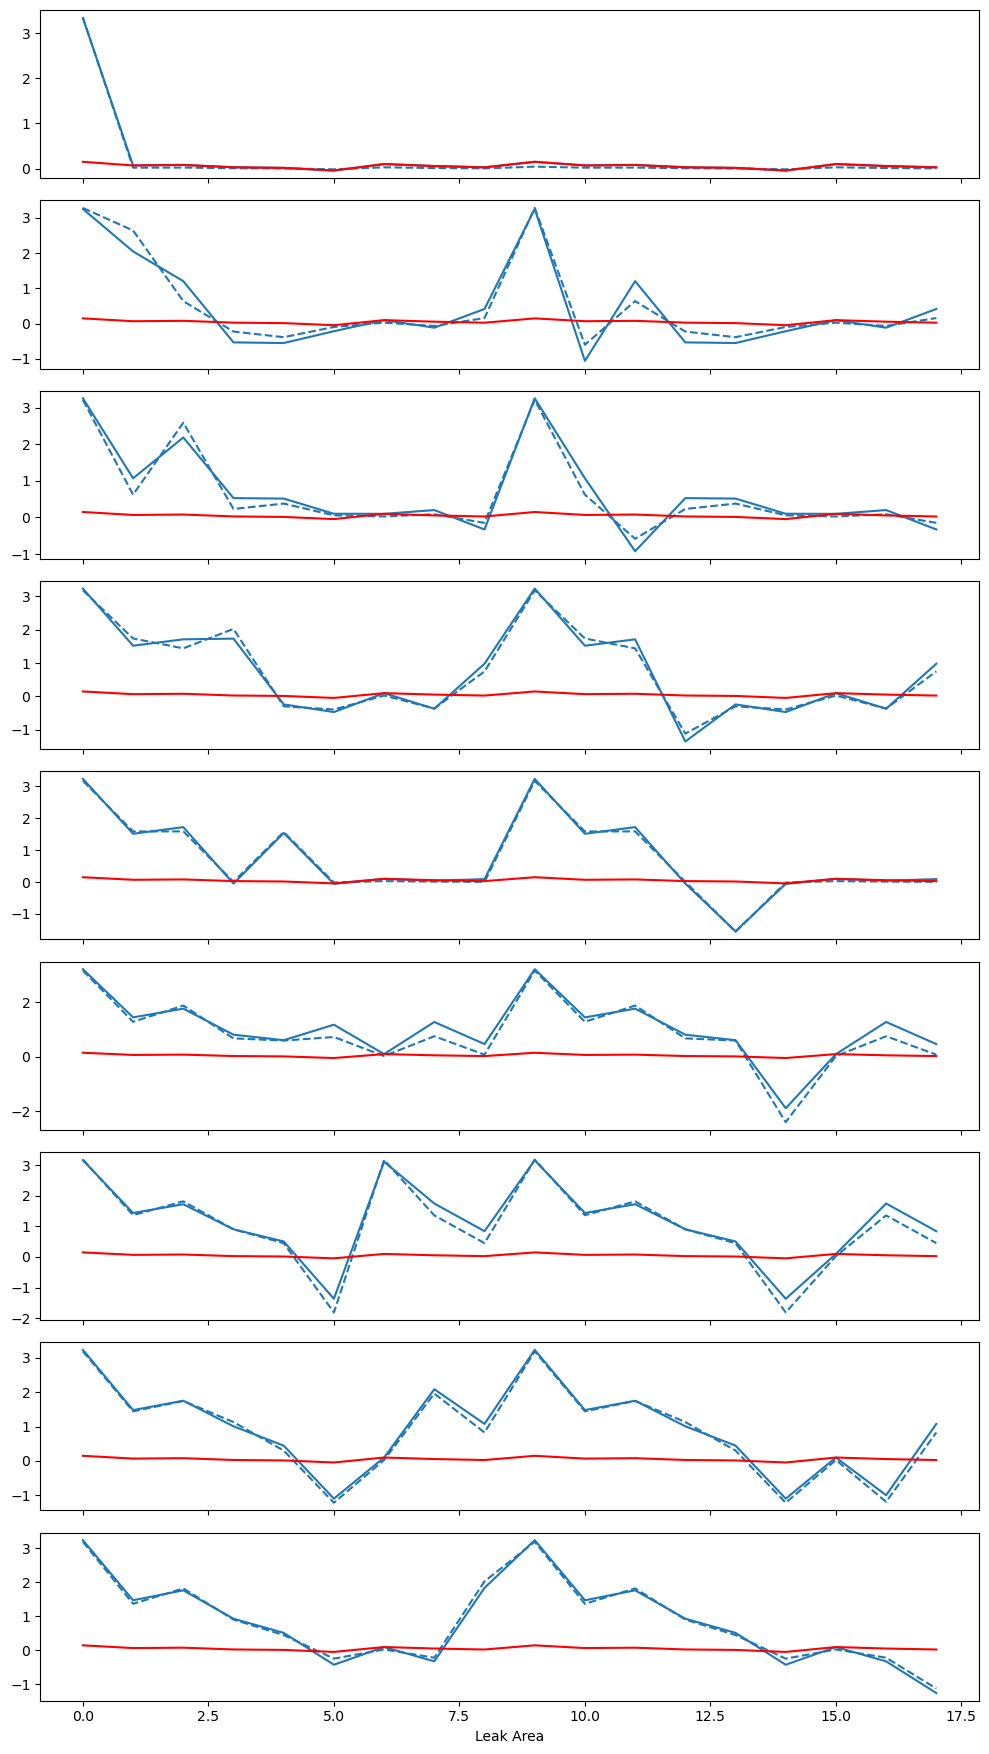

In [8028]:
model.eval()
true_df = flow_df.drop(columns=['Leak Area'])

fig, axs = plt.subplots(n_pipes, 1, figsize=(10, 2 * n_pipes), sharex=True)
axs = np.atleast_1d(axs)


# Only store legend handles/labels once
legend_handles = []

qs = []
trues = []

for i in range(n_pipes):
    #a = torch.zeros((model.n_samples, n_pipes))
    #a[:,i] = torch.tensor(leak_areas, dtype=torch.float32)
    
    idx = torch.tensor([i], dtype=torch.float32).repeat(model.n_samples)
    #D = torch.stack((0.025 * torch.rand((1)), 0.025 * torch.rand((1)), 0.1 * torch.rand((1))), dim=-1)

    #a = torch.stack((torch.tensor(leak_areas, dtype=torch.float32), idx), dim=-1)
    # q_ = model.net(a)#.detach().numpy()
    # q = model.mv(model.inv.T, q_).detach().numpy()
    
    print(idx.shape)
    
    print(D_base[D_base!=0])

    
    input = torch.cat((D_base[D_base!=0], idx), dim=-1)
    
    
    out = torch.clone(model.D)
    out[:,(6.0+idx).long()] = model.net(input)

    #out[:,6+idx] = model.net(idx)
    q = model.mv(model.inv.T, out).detach().numpy()
    
    true_df = flow_df[flow_df['Leak Node ID'] == f'LEAK-{i}'].drop(columns=['Leak Node ID'])
    true = true_df.drop(columns=['Leak Area']).to_numpy()
    pipe_names = list(flow_df.columns[2:])
    
    q_df = pd.DataFrame(q, columns=pipe_names)
    error_df = pd.DataFrame(q - true, columns=pipe_names)
    
    lines = axs[i].plot(np.arange(2*n_pipes), q.T, '--')  # Store the Line2D objects
    for j, line in enumerate(lines):
        color = line.get_color()  # Get color from first plot
        axs[i].plot(np.arange(2*n_pipes), true[j,:], color=color)  # Use same color
        
    axs[i].plot(np.arange(2*n_pipes), true[-1,:], color='red')  # Use same color
    
    
    # q_df.insert(0, 'Leak Area', leak_areas)
    # error_df.insert(0, 'Leak Area', leak_areas)
    
    
    # ax = axs[i]
    
    # affected_idx = get_upstream_idx(wn.to_graph(), f'LEAK-{i}')
    # affected_pipes = np.array(wn.pipe_name_list)[affected_idx]

    # # Plot predicted values and collect handles/labels only once
    # for j, pipe in enumerate(wn.pipe_name_list[:3]):
    #     #line, = ax.plot(q_df['Leak Area'], q_df[pipe], label=pipe)
    #     #legend_handles.append(line)

    #     # Plot ground truth as dashed, thick, semi-transparent line
    #     #ax.plot(true_df['Leak Area'], true_df[pipe], color=line.get_color(), linestyle='--', alpha=0.6, linewidth=2)
    #     ax.legend(loc='best')
    #     display(error_df)

    # ax.set_title(f"LEAK-{i}")
    # ax.set_ylabel("Flow")

axs[-1].set_xlabel("Leak Area")

# Shared legend above all subplots
fig.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend


plt.show()


In [ ]:
display(q_df)
display(true_df)
display(error_df)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,3.238369,1.391444,1.846925,0.910962,0.455482,-0.277741,0.1,-0.177741,1.999666,3.238369,1.391444,1.846925,0.910962,0.455482,-0.277741,0.1,-0.177741,-1.088703


,Leak Area,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
16,0.070686,3.23938,1.473653,1.765727,0.932067,0.516585,-0.420424,0.1,-0.320424,1.836888,3.23938,1.473653,1.765727,0.932067,0.516585,-0.420424,0.1,-0.320424,-1.252491
17,0.000000,0.15000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418,0.15000,0.069268,0.080732,0.028692,0.015575,-0.043890,0.1,0.056110,0.027418


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,-0.001010,-0.082208,0.081199,-0.021105,-0.061104,0.142683,3.129244e-08,0.142683,0.162778,-0.001010,-0.082209,0.081199,-0.021105,-0.061104,0.142683,1.490116e-09,0.142683,0.163788
1,3.088369,1.322176,1.766193,0.882270,0.439906,-0.233851,3.129244e-08,-0.233851,1.972249,3.088369,1.322176,1.766193,0.882270,0.439906,-0.233851,1.490116e-09,-0.233851,-1.116121
